### WAV generated by TTS services (internal and external) as references for pronunciation evaluation

- Online TTS (Google) https://gtts.readthedocs.io/en/latest/
- Offline TTS (OS) https://github.com/nateshmbhat/pyttsx3


In [1]:
!pip install gTTS
!pip install pyttsx3

In [2]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate, effect):
    waveform = waveform.numpy()

    # num_channels, num_frames = waveform.shape
    num_frames, num_channels = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[:, c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    # figure.suptitle("waveform: " + effect)
    figure.suptitle(effect)


In [3]:
from gtts import gTTS

# https://gtts.readthedocs.io/en/latest/
#
def tts_online(text, output_path):
    tts = gTTS(text)
    tts.save(output_path)
    

In [4]:
import pyttsx3

# Offline TTS engine
#
# https://github.com/nateshmbhat/pyttsx3
#
engine = pyttsx3.init()

""" RATE"""
rate = engine.getProperty('rate')           # getting details of current speaking rate, 200 default
print(rate)
engine.setProperty('rate', 150)             # setting up new voice rate

"""VOLUME"""
volume = engine.getProperty('volume')       # getting to know current volume level (min=0 and max=1)
print(volume)
engine.setProperty('volume', 1.0)           # setting up volume level  between 0 and 1

"""VOICE"""
voices = engine.getProperty('voices')       # getting details of current voice
engine.setProperty('voice', voices[0].id)  # changing index, changes voices. o for male
# engine.setProperty('voice', voices[1].id)   # changing index, changes voices. 1 for female

engine.runAndWait()

print("offline TTS rate:", engine.getProperty('rate'))      # current voice rate
print("offline TTS volume:", engine.getProperty('volume'))  # current volume level
print("offline TTS voices:", voices)                        # current voice

def tts_offline(text, output_path):
    engine.save_to_file(text, output_path)
    engine.runAndWait()
    

200
1.0
offline TTS rate: 150
offline TTS volume: 1.0
offline TTS voices: [<pyttsx3.voice.Voice object at 0x000001DAF2BC3D90>, <pyttsx3.voice.Voice object at 0x000001DAF2F6CE80>, <pyttsx3.voice.Voice object at 0x000001DAF2D18730>]


### Select between tts_online and tts_offline, by encapsulating either one in tts()


In [7]:
#
# Choose between online TTS and offline TTS
#

def tts(text, output_path):
    tts_online(text, output_path)
    # tts_offline(text, output_path)


1-BWC/arctic_a0001: generated WAV


speaker: BWC
train file: arctic_a0001
train text: Author of the danger trail Philip Steels and etc
BWC/arctic_a0001: waveform.shape: torch.Size([96768, 1]), sample_rate: 24000

speaker: BWC
train file: arctic_a0002
train text: Not at this particular case Tom apologized Whittemore
BWC/arctic_a0002: waveform.shape: torch.Size([98496, 1]), sample_rate: 24000

speaker: BWC
train file: arctic_a0003
train text: For the twentieth time that evening the two men shook hands
BWC/arctic_a0003: waveform.shape: torch.Size([102528, 1]), sample_rate: 24000

speaker: BWC
train file: arctic_a0004
train text: Lord but I'm glad to see you again Phil
BWC/arctic_a0004: waveform.shape: torch.Size([73152, 1]), sample_rate: 24000

speaker: BWC
train file: arctic_a0005
train text: Will we ever forget it
BWC/arctic_a0005: waveform.shape: torch.Size([44928, 1]), sample_rate: 24000

speaker: BWC
train file: arctic_a0006
train text: God bless 'em I hope I will go on seeing them forever
BWC/arctic_a0006: waveform.sh

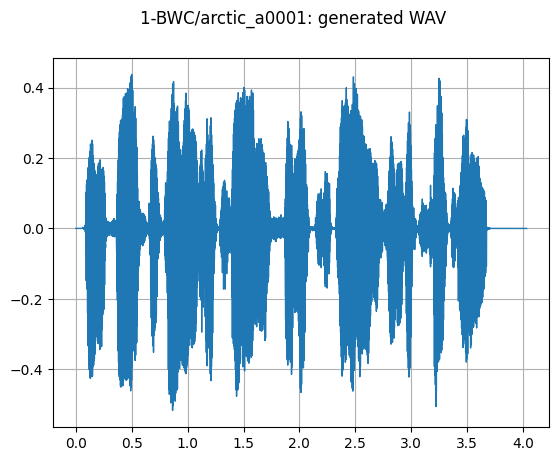

In [8]:
import glob
import os
import random
import shutil
import timeit
import torch
import torchaudio
from IPython.display import display, Audio

t0 = timeit.default_timer()
ti = t0

random.seed(10)

verbose, debug = True, False

sample_count, sample_show, sample_limit = 0, random.randint(1, 9), 10  # 1e5  # sample counter, id-to-show and limit

skipped = []  # "wav"]  # any file generation should be skipped to save time: {"wav", "transcript", "textgrid", "annotation"}
overwritten = []   # any non-skipped generation allows overwritten

input_folder = r"T:\Terence\NUS\CS5647 - Sound and Music Computing\Project\cs4347-project-main\train_data\l2 artic dataset split\*\train"

extensions = {"wav": ".wav", "transcript":".txt", "mp3": ".mp3"}  # mp3 added

counters = {}  # counters to show the output counts

transcript_paths = data_paths = glob.glob(os.path.join(input_folder, "transcript", "*"))  # transcript_paths as a reminder to avoid unexpected code change

for data_path in data_paths:
    if not os.path.isfile(data_path):
        continue

    train_folder, filename = os.path.split(data_path)
    train_folder = os.path.dirname(train_folder)
    filename, ext = os.path.splitext(filename)
    speaker = os.path.basename(os.path.dirname(train_folder))

    # initialize counters per speaker
    #
    if speaker not in counters:
        counters[speaker] = {}
        for counter in extensions.keys():
            counters[speaker]["src_" + counter] = 0
            counters[speaker][counter] = 0
    
    src_paths, dst_paths = {}, {}
    for folder, ext in extensions.items():
        src_paths[folder] = os.path.join(train_folder, folder, filename + ext)
        if os.path.exists(src_paths[folder]):
            counters[speaker]["src_" + folder] += 1
        dst_folder = os.path.join(train_folder + '_tts', folder)
        os.makedirs(dst_folder, exist_ok=True)
        dst_paths[folder] = os.path.join(dst_folder, filename + ext)

    text = None
    with open(src_paths["transcript"]) as file:
        text = file.read()
        
    folder = "mp3"
    tts(text, dst_paths[folder])
    if not os.path.exists(dst_paths[folder]):
        print(f"{filename}: MP3 not generated")
        continue

    sample_count += 1

    # save the output files and update the counters
    #
    for folder in extensions.keys():
        if (True or not os.path.exists(dst_paths[folder]) or folder in overwritten) and folder not in skipped:
            if folder in ("wav",):
                waveform, sample_rate = torchaudio.load(dst_paths["mp3"], channels_first=False)
                torchaudio.save(dst_paths[folder], waveform, sample_rate, channels_first=False)
            elif folder in ("annotation", "textgrid"):
                continue
                # textgrid_save(src_paths[folder], dst_paths[folder], effects[0][i % 3])
            elif folder in ("transcript",):
                shutil.copyfile(src_paths[folder], dst_paths[folder])
        if os.path.exists(dst_paths[folder]):
            counters[speaker][folder] += 1

    if sample_count == sample_show:
        folder = "wav"
        if os.path.exists(dst_paths[folder]):
            label = f"{sample_show}-{speaker}/{filename}: generated WAV"
            print(label)
            display(Audio(dst_paths[folder]))
            waveform, sample_rate = torchaudio.load(dst_paths[folder], channels_first=False)
            plot_waveform(waveform, sample_rate, label)
    
    if verbose:
        print("speaker:", speaker)
        print("train file:", filename)
        print("train text:", text)
        waveform, sample_rate = torchaudio.load(dst_paths["wav"], channels_first=False)
        print(f"{speaker}/{filename}: waveform.shape: {waveform.shape}, sample_rate: {sample_rate}")
        print()

    if sample_count >= sample_limit:
        break

time_elapsed = timeit.default_timer() - ti
print("time elapsed in minutes:", time_elapsed / 60)
